# 测试部分

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
#font_manager.fontManager.addfont("/home/yltang/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Times New Roman.ttf")

In [2]:
plt.style.use('classic')
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 15,
         }

In [3]:
#加载数据
train_data_file = np.load(f'/data/yltang/simulated_data_1/data_new/concated_data/final_data/SNIa.npz')
train_data = train_data_file["data"]
train_label = train_data_file["label"]

In [4]:
train_data.shape

(1800, 40, 6)

In [5]:
num=100
num_band = 3
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']
labels = ['u','g','r','i','z','y']
sampling_intervals=1

101


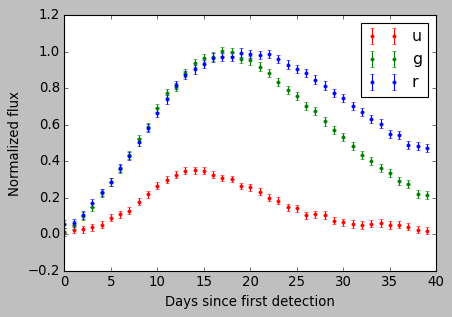

In [6]:
import matplotlib.pyplot as plt
num = num + 1
plt.figure(figsize=(6,4))
for i in range(num_band):
    mjd = np.linspace(0,int(40/sampling_intervals)-1,int(40/sampling_intervals))
    observed_flux = train_data[num,:,i]
    observed_flux_err = train_data[num,:,i+num_band]
    
    plt.errorbar(x=mjd, y=observed_flux, yerr=observed_flux_err, fmt=fmt[i], capsize=2,label=labels[i])
    plt.legend()

    plt.xlabel("Days since first detection")
    plt.ylabel("Normalized flux")
print(num)

In [7]:
sample_index = num

In [8]:
train_data[sample_index].shape

(40, 6)

## 下采样

In [73]:
#第一次随机下采样
time_to_observed = 40
observable_data = int(time_to_observed*0.4)


# 定义范围
lower_bound = 0
upper_bound = time_to_observed
num_unique_numbers_needed = observable_data

# 创建指定范围内的所有整数列表
all_numbers = np.arange(lower_bound, upper_bound)

# 使用choice函数从中随机选择不重复的数字
unique_random_numbers = np.random.choice(all_numbers, num_unique_numbers_needed, replace=False)
observed_index = np.sort(unique_random_numbers)

# 输出结果
observed_index[:]

array([ 2,  5,  9, 10, 12, 13, 14, 16, 17, 19, 21, 25, 26, 27, 29, 33])

In [74]:
#需要重新截断部分数据
observed_index = np.append(observed_index, [ 0,  0,  1,  1,  2,  3,  4,  4,  5, 11, 14, 16, 17, 19, 39 ])
observed_index = np.sort(observed_index)
observed_index[:]

array([ 0,  0,  1,  1,  2,  2,  3,  4,  4,  5,  5,  9, 10, 11, 12, 13, 14,
       14, 16, 16, 17, 17, 19, 19, 21, 25, 26, 27, 29, 33, 39])

In [23]:
observed_index = np.array([ 2,  3,  8,  9, 14, 16, 18, 21, 23, 24, 26, 29, 30, 31, 35, 41, 44,
       46, 47, 49, 52, 53, 55, 57, 59, 61, 62, 65, 66, 71, 75, 79, 82, 83,
       85, 88, 89])

In [75]:
observed_index = observed_index[:]
observable_data = int(len(observed_index))

In [76]:
mjd_original = np.linspace(0,int(40/sampling_intervals)-1,int(40/sampling_intervals))
mjd = np.zeros(shape=(3,observable_data))
flux = np.zeros(shape=(3,observable_data))
flux_err = np.zeros(shape=(3,observable_data))
for  j, observed_index_ in enumerate(observed_index):
    for i in range(3):
        mjd[i,j] = mjd_original[observed_index_]
        flux[i,j] = train_data[num, observed_index_,i]
        flux_err[i,j] = train_data[num, observed_index_, i+num_band]

In [77]:
len(mjd[0]), len(flux[0])

(31, 31)

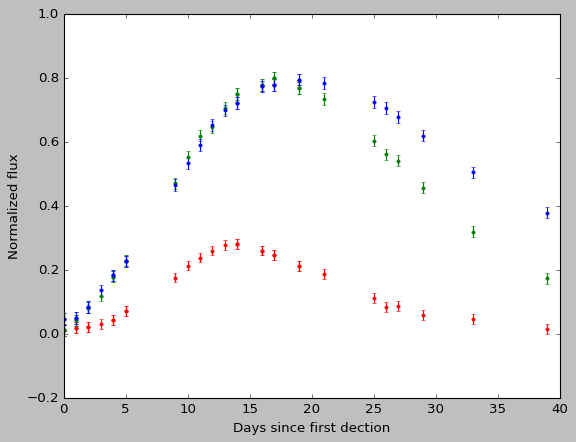

In [78]:
import matplotlib.pyplot as plt
fmt = ['.r','.g','.b','.k','.y','.m']
plt.figure(figsize=(8,6))
for i in range(3):
    plt.errorbar(x=mjd[i], y=flux[i]*0.8, yerr=flux_err[i]*0.8, fmt=fmt[i], capsize=2)
    plt.xlabel("Days since first dection")
    plt.ylabel("Normalized flux")

In [79]:
#central_wave_length = [3570.0,4767.0,6215.0,7545.0,8708.0,10040.0]
central_wave_length = [3570.0,4767.0,6215.0]
central_wave_length = np.array(central_wave_length)

In [80]:
mjd_stack = np.hstack([mjd[0],mjd[1],mjd[2]])
flux_stack = np.hstack([flux[0],flux[1],flux[2]])
flux_err_stack = np.hstack([flux_err[0],flux_err[1],flux_err[2]])
wavelength_stack = np.hstack([np.ones(shape=mjd[0].shape)*central_wave_length[0],
                              np.ones(shape=mjd[1].shape)*central_wave_length[1],
                             np.ones(shape=mjd[2].shape)*central_wave_length[2]])

In [81]:
gind = np.argsort(mjd_stack)
time = mjd_stack[gind]
fluxes = flux_stack[gind]
flux_errs = flux_err_stack[gind]
filters = wavelength_stack[gind]

Text(0, 0.5, 'flux')

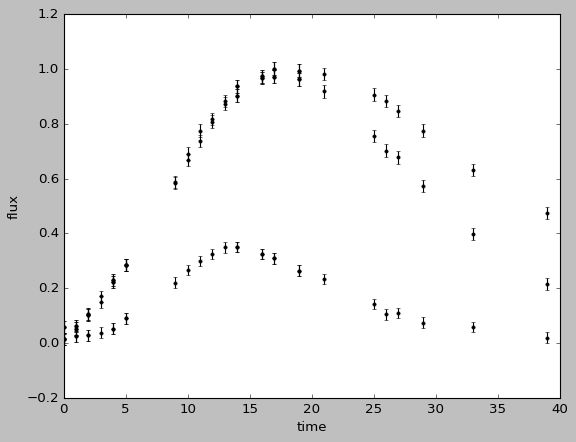

In [82]:
plt.errorbar(x=time, y=fluxes, yerr=flux_errs, fmt=".k", capsize=2)
plt.xlabel("time")
plt.ylabel("flux")

In [83]:
import george

In [84]:
signal_to_noises = np.abs(fluxes) / np.sqrt(
            flux_errs ** 2 + (1e-2 * np.max(fluxes)) ** 2
        )
index = np.argmax(signal_to_noises)
scale = np.abs(fluxes[index])
scale

1.0010113510497316

In [85]:
index = np.argmax(fluxes)
scale = np.abs(fluxes[index])
scale

1.0010113510497316

In [86]:
from george import kernels
guess_length_scale=20.0
kernel = (0.5 * scale) ** 2 * kernels.Matern32Kernel(
            [guess_length_scale ** 2, 6000 ** 2], ndim=2
        )
kernel

ConstantKernel(log_constant=-2.077419861722214, ndim=2, axes=array([0, 1])) * Matern32Kernel(metric=Metric(array([4.0e+02, 3.6e+07]), ndim=2, axes=array([0, 1]), bounds=[(None, None), (None, None)]), block=None)

In [87]:
x_ = np.vstack([time, filters]).T
x_.shape

(93, 2)

In [88]:
gp = george.GP(kernel)
gp.compute(x_, flux_errs)

In [89]:
x_pred = np.linspace(min(time), max(time), 500)
x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[0]])

In [90]:
pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)

In [91]:
x_pred_ = x_pred[0,:]
x_pred_.shape

(500,)

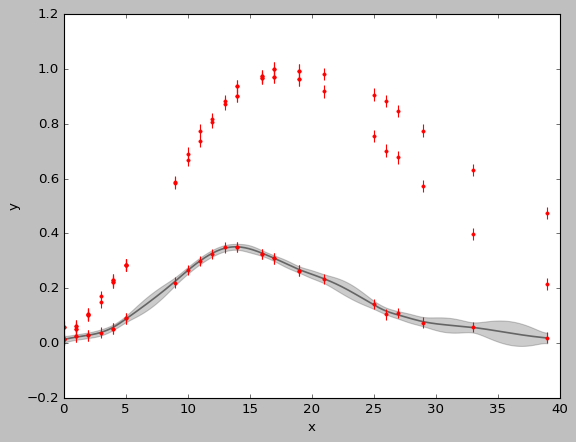

In [92]:
plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred_, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(time, fluxes, yerr=flux_errs, fmt=".r", capsize=0)


plt.xlabel("x")
plt.ylabel("y");

In [93]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(fluxes)))

Initial ln-likelihood: 180.88


In [94]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(fluxes)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(fluxes)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(fluxes)))

      fun: -198.23924957012076
 hess_inv: array([[0.72995054, 0.52194886, 0.55659242],
       [0.52194886, 0.41479712, 0.41333288],
       [0.55659242, 0.41333288, 0.57686364]])
      jac: array([ 1.12756365e-06, -2.12014902e-06,  2.79906473e-07])
  message: 'Optimization terminated successfully.'
     nfev: 13
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([-1.88143906,  7.12976022, 16.64609967])

Final ln-likelihood: 198.24


In [95]:
band = 0

In [96]:
x_pred = np.linspace(min(time), max(time), 30)
x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])

In [97]:
pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)

In [98]:
x_pred_ = x_pred[0,:]
x_pred_.shape

(30,)

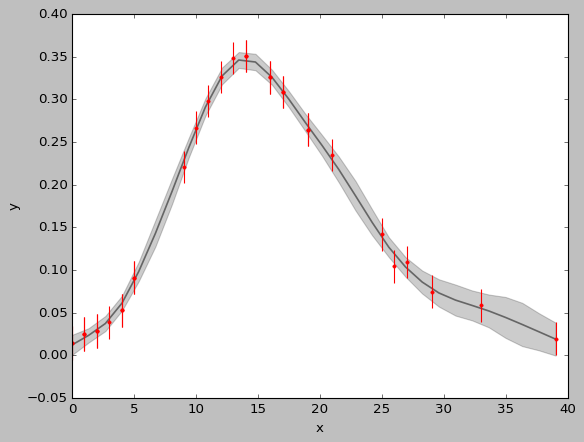

In [99]:
plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred_, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(mjd[0], flux[band], yerr=flux_err[band], fmt=".r", capsize=0)


plt.xlabel("x")
plt.ylabel("y");

In [100]:
color = ['r','g','b','k','y','m']

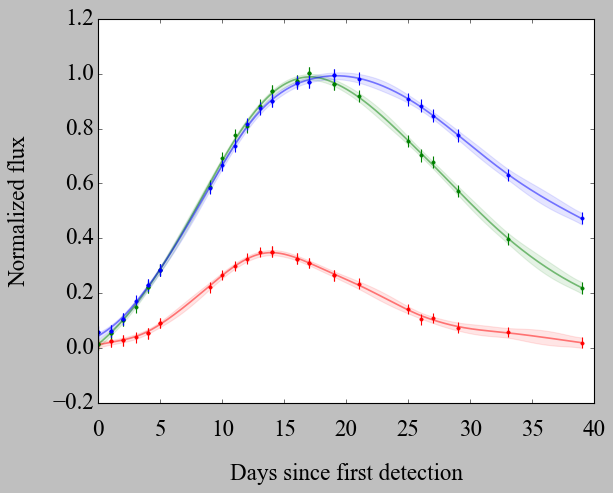

In [101]:
plt.figure(figsize=(8,6))
for band in range(3):
    x_pred = np.linspace(0, max(time), 300)
    #print(x_pred)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    plt.fill_between(x_pred_, pred -  np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.1)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.5)
    plt.errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0)

    plt.xlabel("Days since first detection",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.ylabel("Normalized flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")

    plt.xticks(fontsize="xx-large",position=(0, -0.03),fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")

In [39]:
x_pred_list = []
pred_list = []
pred_var_list = []

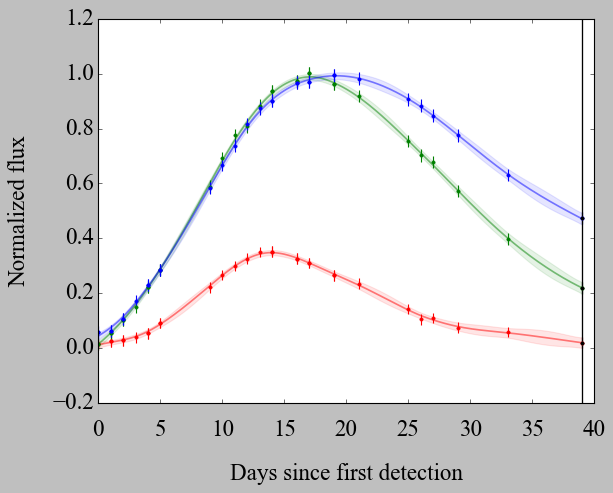

In [102]:
plt.figure(figsize=(8,6))
x_pred_list_ = []
pred_list_ = []
pred_var_list_ = []

for band in range(3):
    x_pred = np.linspace(0, max(time), 300)
    #print(x_pred)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    
    x_pred_list_.append(x_pred)
    pred_list_.append(pred)
    pred_var_list_.append(pred_var)
    
    plt.fill_between(x_pred_, pred -  np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.1)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.5)
    plt.errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0)
    plt.errorbar(np.linspace(max(time),int(40/sampling_intervals)-1,int(40/sampling_intervals-max(time)))
                 , train_data[num,int(max(time)):,band], yerr=train_data[num,int(max(time)):,band+3], fmt="k.", capsize=0)
    
    plt.xlabel("Days since first detection",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.ylabel("Normalized flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")

    plt.xticks(fontsize="xx-large",position=(0, -0.03),fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")
    plt.axvline(x=max(time),color="k")

    #plt.savefig(f"Real_time_interpolation_{observable_data}.jpg",bbox_inches='tight')

In [103]:
x_pred_list.append(x_pred_list_)
pred_list.append(pred_list_)
pred_var_list.append(pred_var_list_)

## 保存数据

In [104]:
label = ["u","g","r"]

In [121]:
# 1. 相关模块导入
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 正常显示中文字体
#plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 3. 绘图
  # 3.1 共享y轴
figure,(ax1,ax2,ax3) = plt.subplots(1,3,
                                    figsize=(6*3,5),
                                    dpi=1000,
                                    # 共享y轴
                                    sharey=True)

# 2. 创建制图数据
ax_list = [ax1,ax2,ax3]
for i in range(3):
    for band in range(3):
        x_pred = x_pred_list[i]
        #print(x_pred)
        #x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[i]])
        #pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
        pred = pred_list[i][band]
        pred_var = pred_var_list[i][band]
        x_pred_ = x_pred[band][0,:]
        ax_list[i].fill_between(x_pred_-min(x_pred_), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                   color=color[band], alpha=0.5)
        ax_list[i].plot(x_pred_-min(x_pred_), pred, color[band], lw=1.0, alpha=1.0)
        #plt.xlim(10,120)
        ax_list[i].errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0,label=label[band])
        ax_list[i].axvline(x=max(x_pred_),color="k")
        ax_list[i].errorbar(np.linspace(max(x_pred_),int(40/sampling_intervals)-1,int(40/sampling_intervals-max(x_pred_)))
                 , train_data[num,int(max(x_pred_)):,band], yerr=train_data[num,int(max(x_pred_)):,band+3], fmt="k.", capsize=0)
        #ax_list[j].errorbar(x=mjd_1, y=flux_list[j], yerr=flux_err_list[j],color=color[i], marker=markers[i], capsize=2,label=label[i])
        
        if i==0:
            ax_list[i].set_ylabel("Normalized Flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
        elif i==1:
            ax_list[i].set_xlabel("Times",fontsize="xx-large", labelpad=30,fontproperties="Times New Roman")
        #ax_list[i].legend(fontsize="xx-large",loc="upper right",prop=font1)

        ax_list[i].legend(fontsize="xx-large",
                      #bbox_to_anchor=(0,0.34,1.028, 1),
                      loc="upper right",
                      framealpha=0.2,
                      prop=font1
                     )
        
        #设置坐标轴字体
        x1_label = ax_list[i].get_xticklabels() 
        [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
        y1_label = ax_list[i].get_yticklabels() 
        [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    
        #ax_list[j].set_ylim(-0.3,1.2)
            
        # 2.4 坐标轴刻度字体颜色设置
        ax_list[i].tick_params(axis='y',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
        ax_list[i].tick_params(axis='x',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 


# 调整子图形之间的纵向距离
figure.subplots_adjust(wspace=0.07) 

plt.savefig("Real_time_interpolation.jpg",bbox_inches='tight')

plt.show()

In [168]:
def gp_augmentation(light_curve,central_wave_length_shift):
    import george
    import numpy as np
    from george import kernels
    from tqdm import tqdm
    guess_length_scale=20.0
    central_wave_length = [3570.0,4767.0,6215.0] 
    central_wave_length = np.array(central_wave_length)
    sythetic_light_curve = np.ones([light_curve.shape[0],light_curve.shape[1],light_curve.shape[2]])
    delet_list = []
    with tqdm(total=light_curve.shape[0]*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for sample_index in range(light_curve.shape[0]):
            mjd = []
            flux = []
            flux_err = []
            for band in range(3):
                mjd_ = light_curve[sample_index, :,-1] + np.linspace(0,int(90/sampling_intervals)-1,int(90/sampling_intervals))
                flux_ = light_curve[sample_index, :,band]
                flux_err_ = light_curve[sample_index, :,band + 3]
                
                mjd.append(mjd_)
                flux.append(flux_)
                flux_err.append(flux_err_)
        
            mjd_stack = np.hstack([mjd[0],mjd[1],mjd[2]])
            flux_stack = np.hstack([flux[0],flux[1],flux[2]])
            flux_err_stack = np.hstack([flux_err[0],flux_err[1],flux_err[2]])
            wavelength_stack = np.hstack([np.ones(shape=mjd[0].shape)*central_wave_length[0],
                                          np.ones(shape=mjd[1].shape)*central_wave_length[1],
                                         np.ones(shape=mjd[2].shape)*central_wave_length[2]])
        
            gind = np.argsort(mjd_stack)
            time = mjd_stack[gind]
            fluxes = flux_stack[gind]
            flux_errs = flux_err_stack[gind]
            filters = wavelength_stack[gind]
            signal_to_noises = np.abs(fluxes) / np.sqrt(
                flux_errs ** 2 + (1e-2 * np.max(fluxes)) ** 2
            )
            index = np.argmax(signal_to_noises)
            scale = np.abs(fluxes[index])
            kernel = (0.5 * scale) ** 2 * kernels.Matern32Kernel(
                        [guess_length_scale ** 2, 6000 ** 2], ndim=2)
        
            x_ = np.vstack([time, filters]).T
            gp = george.GP(kernel)
            gp.compute(x_, flux_errs)
    
            from scipy.optimize import minimize
            def neg_ln_like(p):
                gp.set_parameter_vector(p)
                return -gp.log_likelihood(fluxes)
            def grad_neg_ln_like(p):
                gp.set_parameter_vector(p)
                return -gp.grad_log_likelihood(fluxes)
            try:
                result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
                gp.set_parameter_vector(result.x)
                central_wave_length_ = []
                #for j in range(light_curve.shape[1]):
                #   sythetic_light_curve[sample_index, j, -1] = light_curve[sample_index, j, -1]
                
                for band in range(3):
                    central_wave_length_.append(central_wave_length[band] + central_wave_length_shift)
                    x_pred = np.linspace(min(time), max(time), light_curve.shape[1])
                    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
                    pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
                    x_pred_ = x_pred[0,:]
            
                    for j in range(light_curve.shape[1]):
                        sythetic_light_curve[sample_index,j,band] = pred[j]
                        sythetic_light_curve[sample_index,j,band + 3] = 2 * np.sqrt(pred_var[j])
            except:
                delet_list.append(sample_index)

            pbar.update(10)
    sythetic_light_curve = np.delete(sythetic_light_curve, delet_list, axis=0)

    return sythetic_light_curve

In [39]:
import numpy as np
a = np.ones([3,2,3])

In [40]:
a[1,:,:]=2

In [41]:
a

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[2., 2., 2.],
        [2., 2., 2.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [42]:
a = np.delete(a,[1,2],axis=0)
a

array([[[1., 1., 1.],
        [1., 1., 1.]]])

## 测试该函数

In [43]:
import numpy as np

train_data_file = np.load(f'/data/yltang/simulated_data_1/data_2023_12/train_data_cl.npz')
train_data = train_data_file["observing_data"]
train_data_original = train_data_file["original_observing_data"]
train_label = train_data_file["label"]

In [44]:
num=0
num_band = 3
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']
labels = ['u','g','r','i','z','y']
sampling_intervals=3

In [45]:
train_data.shape

(1180, 30, 7)

In [51]:
sythetic_light_curve = gp_augmentation(light_curve=train_data,central_wave_length_shift=100)

Processing...: 100%|█████████████████████████████████████████████| 11.8k/11.8k [01:05<00:00, 180B/s]


In [52]:
sythetic_light_curve.shape

(1169, 30, 7)

0


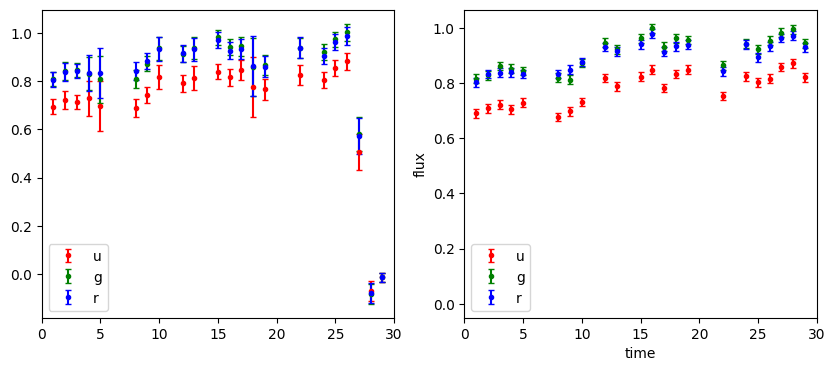

In [53]:
import matplotlib.pyplot as plt
sample_index = 0
plt.figure(figsize=(5*2,4))
for i in range(num_band):
    mjd = np.linspace(0,int(90/sampling_intervals)-1,int(90/sampling_intervals))
    mjd_1 = mjd + sythetic_light_curve[sample_index, :, -1]
    mjd_2 = mjd + train_data[sample_index, :, -1]

    observed_flux = train_data[sample_index,:,i]
    observed_flux_err = train_data[sample_index,:,i+num_band]

    sythetic_flux = sythetic_light_curve[sample_index,:,i]
    sythetic_flux_err = sythetic_light_curve[sample_index,:,i+3]
    
    plt.subplot(1,2,1)
    plt.errorbar(x=mjd_1, y=sythetic_flux, yerr=sythetic_flux_err, fmt=fmt[i], capsize=2,label=labels[i])
    plt.xlim(0,30)
    plt.legend()

    plt.subplot(1,2,2)
    plt.errorbar(x=mjd_2, y=observed_flux, yerr=observed_flux_err, fmt=fmt[i], capsize=2,label=labels[i])
    plt.xlim(0,30)
    plt.legend()
    #plt.xlim(min(mjd),observing_data[num,0,-1]+time_window)
    #for j in Nan_data_position_list[num]:
    #    plt.axvline(x=j)
    plt.xlabel("time")
    plt.ylabel("flux")
print(num)